# Milwaukee Labels - Examine to prepare for split

In [1]:
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json # for working with JSON files 
from PIL import Image # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

pd.set_option('max_colwidth', -1)

# Load Labels Metadata

In [2]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'
LABELS_PATH = os.path.join(SAGEMAKER_PATH, r'EDA/Formatting_Data/data/all_labels.csv')
df_labels = pd.read_csv(LABELS_PATH)
print(df_labels.shape)
df_labels.head()

(3440, 8)


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680


In [3]:
df_labels.dtypes

filename                   object
file_size                  int64 
file_attributes            object
region_count               int64 
region_id                  int64 
region_shape_attributes    object
region_attributes          object
img_id                     int64 
dtype: object

In [4]:
# Describe numeric columns
df_labels.describe()

,file_size,region_count,region_id,img_id
count,3440.000000,3440.000000,3440.000000,3440.000000
mean,56125.645640,2.072384,0.618023,10776.093605
std,15360.090525,1.656183,1.033051,5794.164809
min,8840.000000,0.000000,0.000000,92.000000
25%,44784.250000,1.000000,0.000000,6053.000000
50%,52721.000000,2.000000,0.000000,9716.000000
75%,65066.250000,3.000000,1.000000,17005.000000
max,112965.000000,7.000000,6.000000,19316.000000


In [5]:
# Number of images
df_labels['filename'].unique().shape

(2192,)

In [6]:
# Number of panos
df_labels['img_id'].unique().shape

(548,)

In [7]:
# Look at labels distribution
df_labels['region_attributes'].value_counts()

{"Present Curb Ramp":"2"}                                          704
{}                                                                 563
{"Present Curb Ramp":"1"}                                          457
{"No Sidewalk":"1"}                                                428
{"Present Curb Ramp":"3"}                                          419
{"Surface Problem":"1"}                                            355
{"Present Curb Ramp":"4"}                                          90 
{"Obstacle":"1"}                                                   72 
{"Surface Problem":"2"}                                            54 
{"Obstacle":"3"}                                                   39 
{"Missing Curb Ramp":"1"}                                          39 
{"Missing Curb Ramp":"2"}                                          38 
{"Surface Problem":"3"}                                            34 
{"Occlusion":"1"}                                                  25 
{"Obst

## Observations
* Need to match img_id back to the pano_id to get the associated depth data
* File size is likely an indicator of image quality
* There are 548 unique panos
* There are 3440 rows
* There are 2192 unique images
* The image labels are in json with the label and the severity 
* Some of the attributes are grouped together - surprised to see this
* Maximum region count is 7

## Look at unique image totals

In [8]:
# Get a DF with just filename and region_count and img_id
file_cols = ['filename', 'region_count', 'img_id']
df_file = df_labels[file_cols].drop_duplicates()
print(df_file.shape)
df_file.head()

(2192, 3)


,filename,region_count,img_id
0,680_45.jpg,3,680
3,680_135.jpg,6,680
9,680_225.jpg,4,680
13,680_315.jpg,1,680
14,877_45.jpg,0,877


In [9]:
# Look at the labels per filename
print(df_file['region_count'].sum())
df_file['region_count'].describe()

2877


count    2192.000000
mean     1.312500   
std      1.237062   
min      0.000000   
25%      0.000000   
50%      1.000000   
75%      2.000000   
max      7.000000   
Name: region_count, dtype: float64

# Train/Test Split

Initial Split - try to get about 100 of each label

In [18]:
df_labels['present_ramp'] = (df_labels['region_attributes'].str.contains('Present'))
df_labels.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True


In [21]:
df_labels['missing_ramp'] = (df_labels['region_attributes'].str.contains('Missing'))
df_labels['obstacle'] = (df_labels['region_attributes'].str.contains('Obstacle'))
df_labels['surface_prob'] = (df_labels['region_attributes'].str.contains('Surface'))
df_labels['no_sidewalk'] = (df_labels['region_attributes'].str.contains('No Sidewalk'))
df_labels['null'] = (df_labels['region_attributes'].str.contains('{}'))
df_labels.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False


In [30]:
# Look at how many are true vs false
cols_bool_labels = ['present_ramp', 'missing_ramp', 'obstacle', 'surface_prob', 'no_sidewalk', 'null']
print(f'Total rows: {df_labels.shape[0]}')
df_labels[cols_bool_labels].sum()

Total rows: 3440


present_ramp    1700
missing_ramp    133 
obstacle        149 
surface_prob    464 
no_sidewalk     431 
null            563 
dtype: int64

In [31]:
df_labels.to_csv('all_labels_bool.csv', index = False)

## Isolate panos with Missing Ramps, Obstacles, and Surface Problems

In [23]:
mask_key_features = (df_labels['missing_ramp'] | df_labels['obstacle'] | df_labels['surface_prob'])
df_key_feat = df_labels.loc[mask_key_features]
print(df_key_feat.shape)
print(df_key_feat['img_id'].unique().shape)
df_key_feat.head()

(745, 14)
(257,)


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null
5,680_135.jpg,51194,{},6,2,"{""name"":""point"",""cx"":266,""cy"":392}","{""Obstacle"":""5""}",680,False,False,True,False,False,False
6,680_135.jpg,51194,{},6,3,"{""name"":""point"",""cx"":545,""cy"":373}","{""Obstacle"":""5""}",680,False,False,True,False,False,False
8,680_135.jpg,51194,{},6,5,"{""name"":""point"",""cx"":591,""cy"":374}","{""Obstacle"":""1\n""}",680,False,False,True,False,False,False
9,680_225.jpg,47450,{},4,0,"{""name"":""point"",""cx"":179,""cy"":411}","{""Surface Problem"":""1""}",680,False,False,False,True,False,False
10,680_225.jpg,47450,{},4,1,"{""name"":""point"",""cx"":427,""cy"":386}","{""Obstacle"":""3""}",680,False,False,True,False,False,False


In [28]:
# For those panos, of interest, see what the breakdown of true is... 
key_feat_img_id_list = list(df_key_feat['img_id'].unique())
df_key_pano = df_labels.loc[df_labels['img_id'].isin(key_feat_img_id_list)]
df_key_pano[cols_bool_labels].sum()

present_ramp    824
missing_ramp    133
obstacle        149
surface_prob    464
no_sidewalk     114
null            179
dtype: int64

In [32]:
df_key_pano.to_csv('key_panos_bool.csv', index = False)

### Comments
* What if we take half of the missing ramp and obstacles? (mimimum of 50 each) 
* Then in training, we'll grab multiple angles of the same images to supplement

# Examine some rows with combined region_attributes

Find that there's a total of 26 such rows where the same point has multiple labels

In [15]:
df_combine = df_labels.loc[df_labels['region_attributes'].str.contains(',')]
print(df_combine.shape)
df_combine

(26, 8)


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id
199,16005_135.jpg,39871,{},2,1,"{""name"":""point"",""cx"":301,""cy"":401}","{""Missing Curb Ramp"":"""",""Present Curb Ramp"":""1""}",16005
1718,4639_225.jpg,54483,{},1,0,"{""name"":""point"",""cx"":267,""cy"":393}","{""Missing Curb Ramp"":"""",""Present Curb Ramp"":""2""}",4639
1976,7699_225.jpg,53969,{},1,0,"{""name"":""point"",""cx"":258,""cy"":480}","{""Missing Curb Ramp"":"""",""Present Curb Ramp"":""3""}",7699
2305,317_315.jpg,62468,{},2,0,"{""name"":""point"",""cx"":204,""cy"":407}","{""Occlusion"":"""",""Obstacle"":""2""}",317
2338,878_135.jpg,41982,{},2,1,"{""name"":""point"",""cx"":419,""cy"":357}","{""Missing Curb Ramp"":""5"",""Obstacle"":""3""}",878
2412,4513_135.jpg,50518,{},4,0,"{""name"":""point"",""cx"":409,""cy"":428}","{""Missing Curb Ramp"":""2"",""Present Curb Ramp"":""3""}",4513
2420,4513_225.jpg,51222,{},5,4,"{""name"":""point"",""cx"":386,""cy"":364}","{""Present Curb Ramp"":""3"",""Missing Curb Ramp"":""""}",4513
2472,4768_45.jpg,93618,{},2,1,"{""name"":""point"",""cx"":250,""cy"":389}","{""Surface Problem"":""1"",""Present Curb Ramp"":""1""}",4768
2484,4945_135.jpg,106853,{},3,2,"{""name"":""point"",""cx"":552,""cy"":422}","{""Present Curb Ramp"":""1"",""Surface Problem"":""1""}",4945
2539,5292_135.jpg,68585,{},2,1,"{""name"":""point"",""cx"":329,""cy"":385}","{""Occlusion"":""1"",""Surface Problem"":""1"",""Present Curb Ramp"":""2""}",5292


In [17]:
df_combine['region_attributes'].value_counts()

{"Present Curb Ramp":"2","Surface Problem":"1"}                    4
{"Surface Problem":"1","Present Curb Ramp":"1"}                    3
{"Present Curb Ramp":"1","Surface Problem":"1"}                    3
{"Surface Problem":"1","Present Curb Ramp":"2"}                    2
{"Missing Curb Ramp":"","Present Curb Ramp":"3"}                   2
{"Missing Curb Ramp":"","Present Curb Ramp":"2"}                   2
{"Surface Problem":"","No Sidewalk":"1"}                           1
{"Missing Curb Ramp":"2","Present Curb Ramp":"3"}                  1
{"Surface Problem":"3","Present Curb Ramp":""}                     1
{"Missing Curb Ramp":"5","Obstacle":"3"}                           1
{"Missing Curb Ramp":"5","Present Curb Ramp":""}                   1
{"Present Curb Ramp":"2","Surface Problem":"2"}                    1
{"Missing Curb Ramp":"","Present Curb Ramp":"1"}                   1
{"Occlusion":"","Obstacle":"2"}                                    1
{"Occlusion":"1","Surface Problem"

# Look at Image 5292
And particularly from heading 135

In [11]:
df_img5292 = df_labels.loc[df_labels['img_id'] == 5292]
df_img5292

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id
2535,5292_45.jpg,53473,{},3,0,"{""name"":""point"",""cx"":258,""cy"":439}","{""Surface Problem"":""1""}",5292
2536,5292_45.jpg,53473,{},3,1,"{""name"":""point"",""cx"":308,""cy"":423}","{""Surface Problem"":""1""}",5292
2537,5292_45.jpg,53473,{},3,2,"{""name"":""point"",""cx"":438,""cy"":387}","{""Surface Problem"":""1""}",5292
2538,5292_135.jpg,68585,{},2,0,"{""name"":""point"",""cx"":204,""cy"":360}","{""Present Curb Ramp"":""2""}",5292
2539,5292_135.jpg,68585,{},2,1,"{""name"":""point"",""cx"":329,""cy"":385}","{""Occlusion"":""1"",""Surface Problem"":""1"",""Present Curb Ramp"":""2""}",5292
2540,5292_225.jpg,74431,{},2,0,"{""name"":""point"",""cx"":261,""cy"":398}","{""Surface Problem"":""1""}",5292
2541,5292_225.jpg,74431,{},2,1,"{""name"":""point"",""cx"":329,""cy"":389}","{""Surface Problem"":""1""}",5292
2542,5292_315.jpg,72803,{},0,0,{},{},5292


In [12]:
# Load and view the images
fs = s3fs.S3FileSystem()

# Docs on s3fs -https://s3fs.readthedocs.io/en/latest/

s3_image_bucket = 's3://streetview-w210'
gsv_dir = os.path.join(s3_image_bucket, 'gsv')

# See what is in the folder
list_gsv_dir = fs.ls(gsv_dir)
print(len(list_gsv_dir))
type(list_gsv_dir)

97126


list

In [13]:
list_5292_gsv = [filename for filename in list_gsv_dir if r'/5292_' in filename]
list_5292_gsv

['streetview-w210/gsv/5292_135.jpg',
 'streetview-w210/gsv/5292_225.jpg',
 'streetview-w210/gsv/5292_315.jpg',
 'streetview-w210/gsv/5292_45.jpg']

streetview-w210/gsv/5292_135.jpg


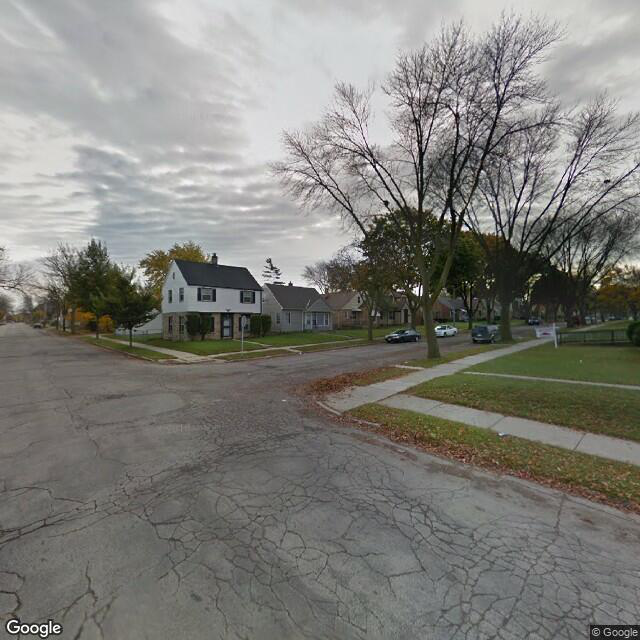

streetview-w210/gsv/5292_225.jpg


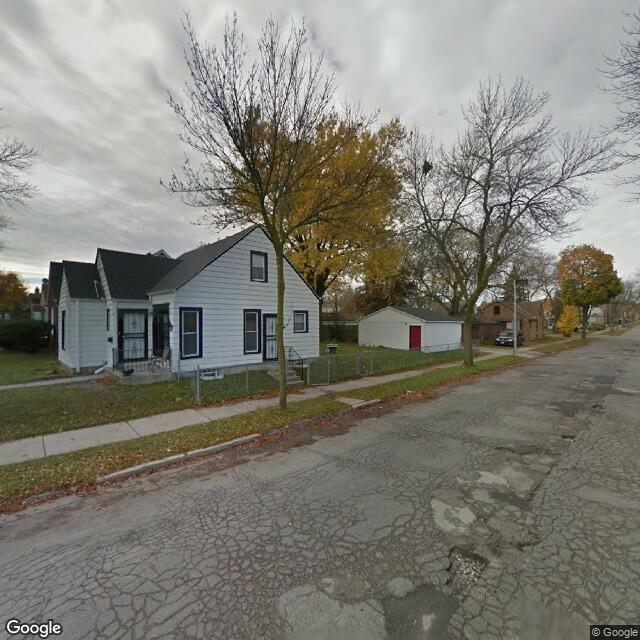

streetview-w210/gsv/5292_315.jpg


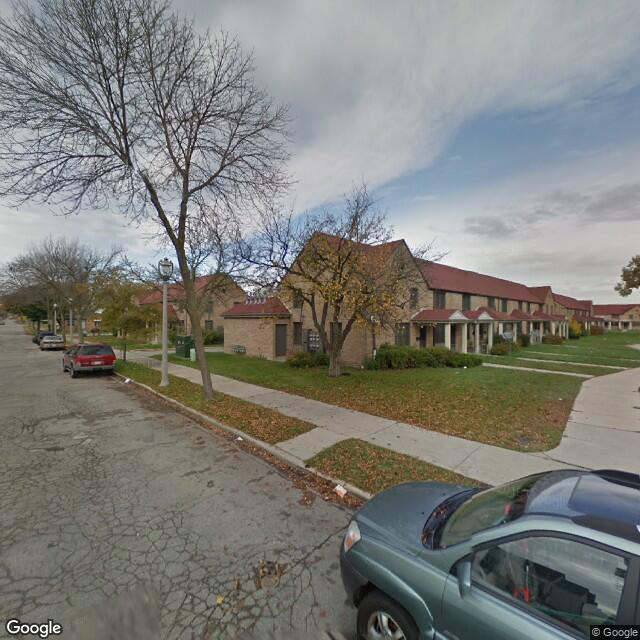

streetview-w210/gsv/5292_45.jpg


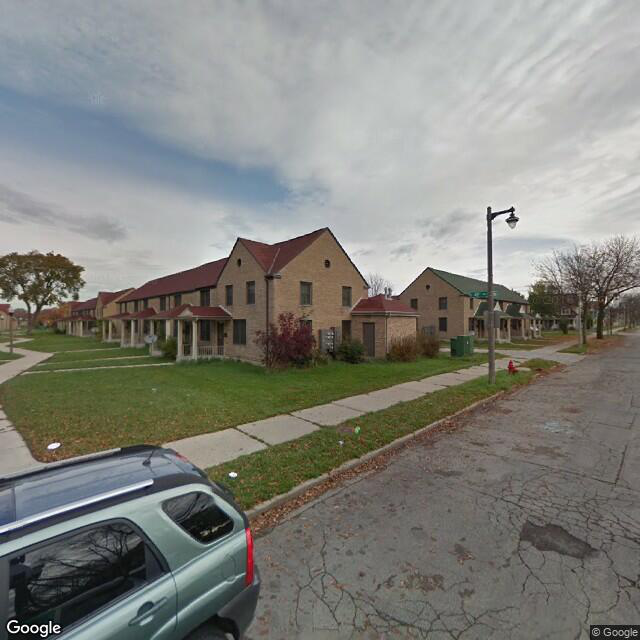

In [14]:
# Most interested in Image 135, but show all 
for image_path in list_5292_gsv:

    # Now let's try to read in the images
    with fs.open(image_path) as f:
        print(image_path)
        display(Image.open(f))